#### Stock Price Prediction using Monte Carlo Simulation.

In [168]:
## Stock Price Prediction, Monte Carlo Simulation.

"Monte Carlo Simulation with Python"
"Stock Price Prediction"
"Felipe Jaramillo Penagos"

'Felipe Jaramillo Penagos'

## Install yfinance package installer

In [169]:
pip install yfinance --upgrade --no-cache-dir 

Note: you may need to restart the kernel to use updated packages.


## Import libraries and data

In [170]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.stats import norm # This package contians probability distributions
                             # and statistical distributions.

In [171]:
## Extract data from Yahoo Finance

ticker = 'MSFT'
stock_data = yf.download(ticker, start='2000-1-1', end='2019-12-31', interval='1d')['Close']

[*********************100%***********************]  1 of 1 completed


In [172]:
# Explore data
stock_data.head()
stock_data.describe()
stock_data.shape

(5030, 1)

## Plot MSFT (Tikcer) Closing Prices

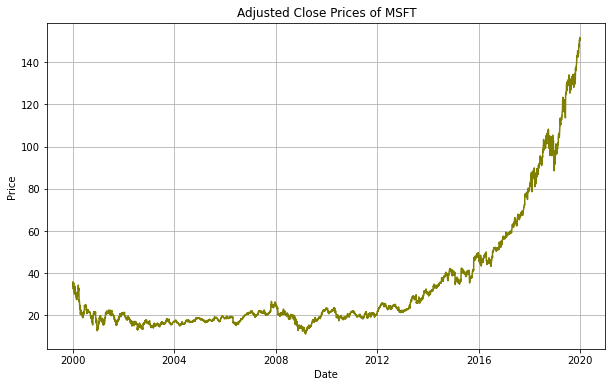

In [173]:
## Plot MSFT closing prices

plt.figure(figsize=(10, 6))
plt.plot(stock_data, color='olive')
plt.title('Adjusted Close Prices of MSFT')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.show()

## Distributions: Plot and Calculate Historical Returns and Statistical Measures

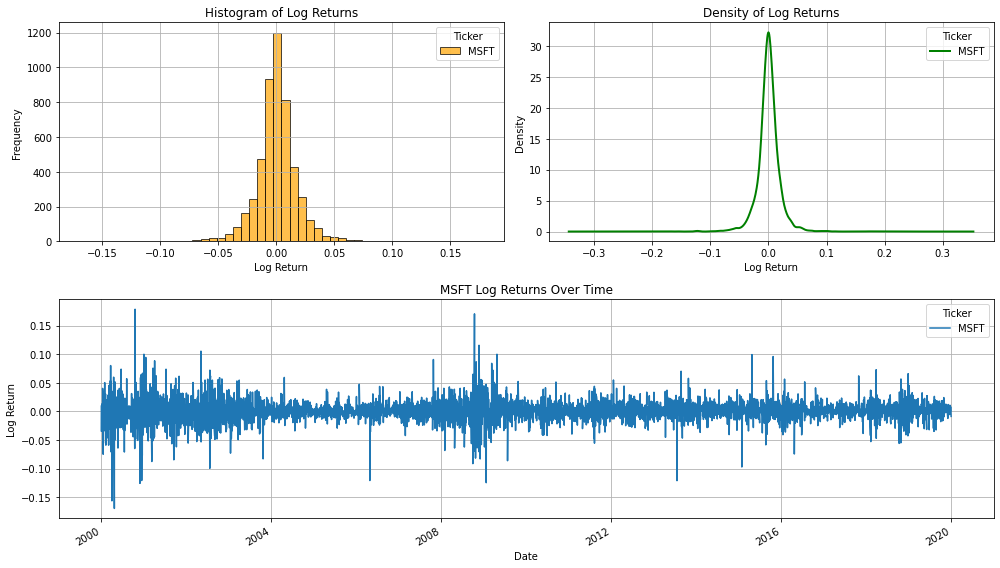

In [174]:
## Distributions - Calculate Historical Returns and Statistical Measures

# Create subplots: 2 rows, 2 columns
fig = plt.figure(figsize=(14, 8))

# Histogram (Top-left)
ax1 = plt.subplot(2, 2, 1)
log_returns.plot.hist(ax=ax1, bins=50, edgecolor='black', color='orange', alpha=0.7)
ax1.set_title('Histogram of Log Returns')
ax1.set_xlabel('Log Return')
ax1.set_ylabel('Frequency')
ax1.grid(True)

# Density (Top-right)
ax2 = plt.subplot(2, 2, 2)
log_returns.plot.density(ax=ax2, color='green', linewidth=2)
ax2.set_title('Density of Log Returns')
ax2.set_xlabel('Log Return')
ax2.grid(True)

# Time-series of Log Returns
ax3 = plt.subplot(2, 1, 2)
log_returns.plot(ax=ax3)
ax3.set_title('MSFT Log Returns Over Time')
ax3.set_xlabel('Date')
ax3.set_ylabel('Log Return')
ax3.grid(True)

plt.tight_layout()
plt.show()


In [175]:
# Calculate Key Statistic Measures
mean = log_returns.mean()
variance = log_returns.var()
sigma = log_returns.std()


print("Mean of log returns:",    mean.item())
print("Variance of log returns:",  variance.item())
print("Standard Deviation:", sigma.item())



Mean of log returns: 0.0002854982838882147
Variance of log returns: 0.0003603306334851679
Standard Deviation: 0.018982376918741443


## Simulate Future Daily Returns and Future Prices


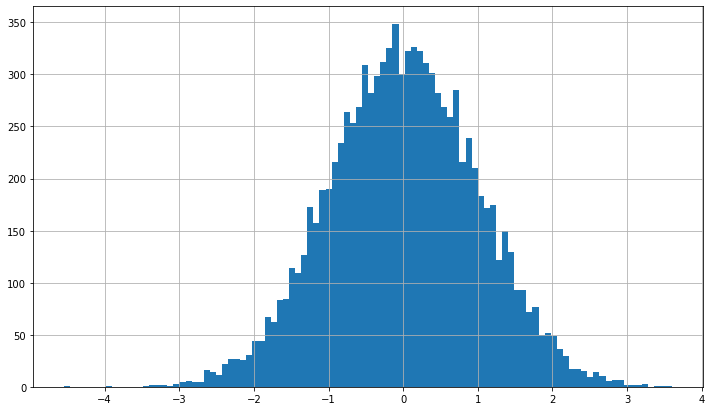

In [176]:
## Simulate Future Daily Returns and Future Prices

# Generate 10,000 random numbers (between 0 and 1)
random_n = np.random.rand(10000)

# Use those randomly generated numbers to sample from a normal distribution
normal_rand_n = norm.ppf(random_n) # The purpose of normal_random_n = norm.ppf(random_numbers) is to convert
                                                 # random numbers from a uniform distribution to a standard normal
                                                 # distribution. 
                                                 # This transformation is useful in various statistical contexts
                                                 # where random numbers (normally distributed are required)
                                                
                                                 # Alt. sample = np.random.normal(loc=0, scale=1, size=n)
                                                 # Alt. 
                                                 #     PDF at x=0
                                                 #     norm.pdf(0, loc=0, scale=1)

                                                 #     CDF at x=1.96
                                                 #     norm.cdf(1.96, loc=0, scale=1)

                                                 #     Inverse CDF (quantile)
                                                 #     norm.ppf(0.975, loc=0, scale=1)
                                                    
# Plot each of the 10,000 numbers from the normal distribution
plt.figure(figsize=(12, 7))
plt.hist(normal_rand_n, bins = 100)
plt.grid()


## Simulate future daily returns using the above 

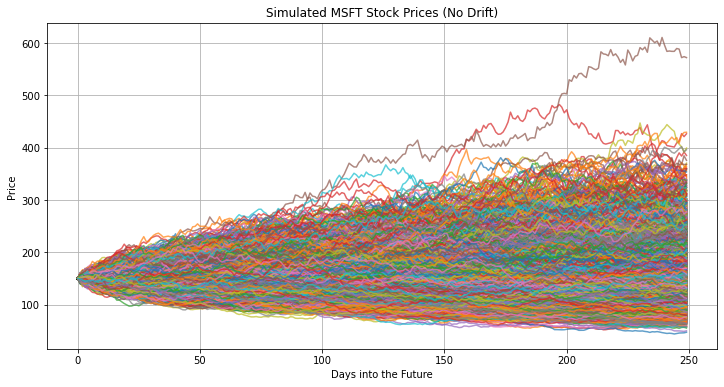

In [177]:
# Step 1: Simulate random normal log returns (no drift)
time_intervals = 250
simulations = 10000 

Z = norm.ppf(np.random.rand(time_intervals, simulations))   # ε ~ N(0,1) (time_intervals, simulations) = 250x10k size
daily_logreturns_sim = sigma.item() * Z                     # σ * ε_t

# Step 2: Convert log returns to simple returns
daily_simplereturns_sim = np.exp(daily_logreturns_sim)      # exp(r_t)

# Step 3: Initialize price simulation array
price_list = np.zeros_like(daily_simplereturns_sim)         # array of 0 same shape as our simulation of prices.
last_price = stock_data.iloc[-1]                            # Last known price
price_list[0] = last_price                                  # First row = starting price

# Step 4: Iteratively compute future prices
for t in range(1, time_intervals):
    price_list[t] = price_list[t - 1] * daily_simplereturns_sim[t] # multiplyig P_t-1 by GBM equation w/o drift.

# Step 5: Plot the simulated price paths
plt.figure(figsize=(12, 6))
plt.plot(price_list, alpha=0.7)  # Light lines for each simulation
plt.title('Simulated MSFT Stock Prices (No Drift)')
plt.xlabel('Days into the Future')
plt.ylabel('Price')
plt.grid(True)
plt.show()


In [178]:
# Each line repersents a simulation w/ a random and unique price evolution drwan
# from a distribution defined by its past behavior.

#### This is a simple driftless GBM MC model. Ahead, we'll include drift into the equation. Attached, a picture of possible ideas and terms to add to the model so it more closely resembles the behavior of the markets.

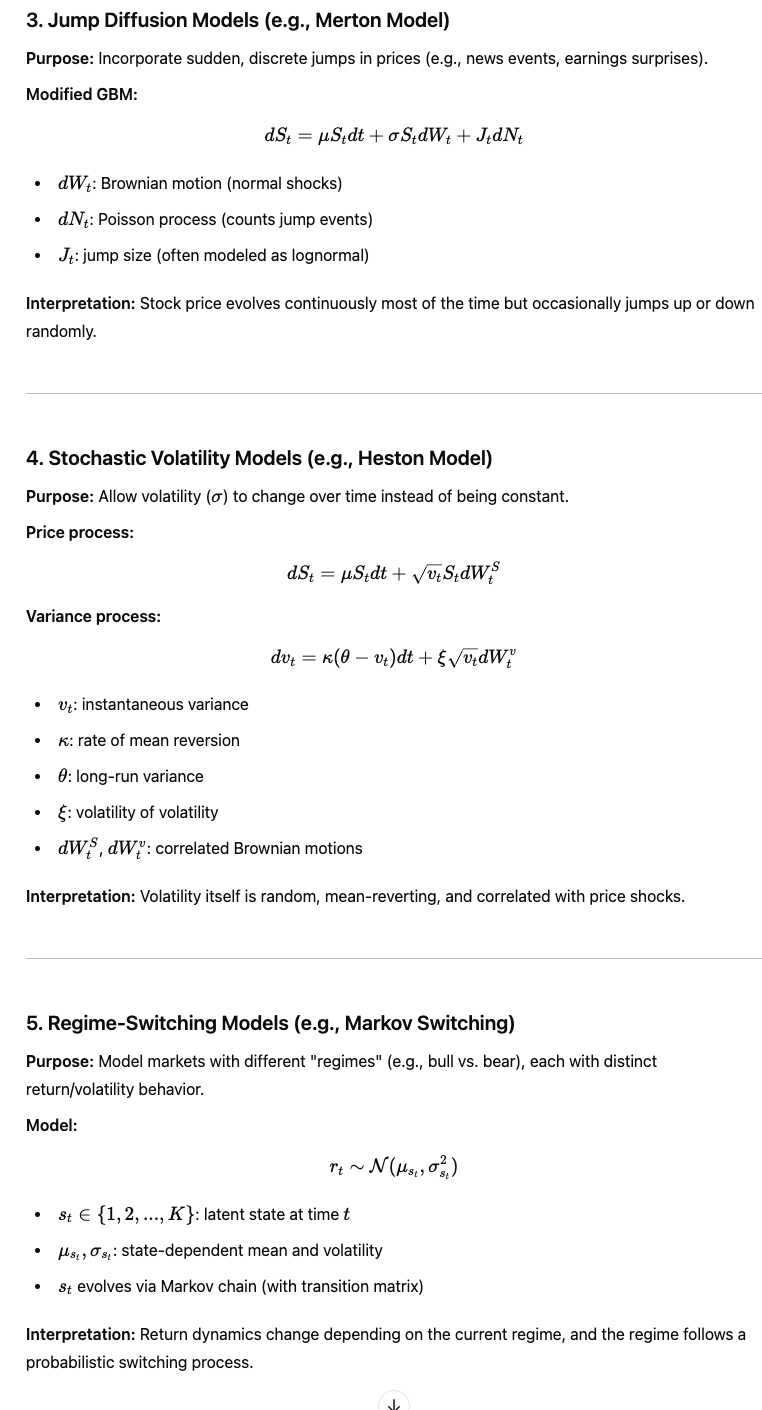

## Geometric Brownian Motion including drift (model again w/ drift included)

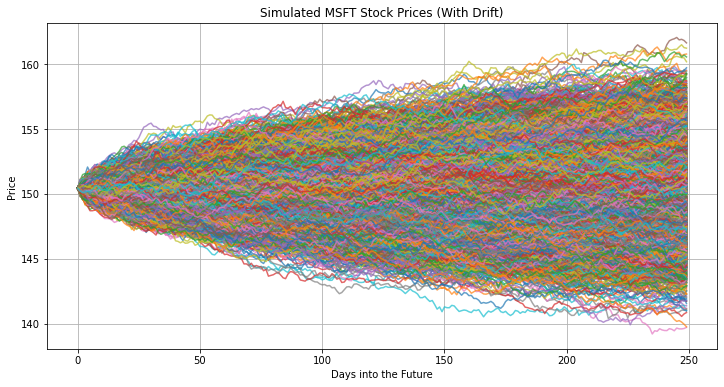

In [179]:
## Including Drift (We'll build the model again w/ drift included)

# Parameters (redefine)
time_intervals = 250        # trading days (1 year)
simulations = 10000         # number of Monte Carlo simulations
dt = 1 / time_intervals     # one-day time step

# Historical stats from real stock data
mu = float(log_returns.mean())     # mean daily log return
sigma = float(log_returns.std())   # std dev (volatility)

# Random shocks ε ~ N(0,1)
Z = np.random.normal(0, 1, size=(time_intervals, simulations)) # (250 trading days)x(10k different values for each)

# Simulate daily log returns with drift
daily_logreturns_sim = (mu - 0.5 * sigma**2) * dt + sigma * Z * np.sqrt(dt)

# Convert to simple returns
daily_simplereturns_sim = np.exp(daily_logreturns_sim)

# Initialize price simulation matrix
price_paths = np.zeros_like(daily_simplereturns_sim)
last_price = stock_data.iloc[-1].item()
price_paths[0] = last_price

# Generate price paths
for t in range(1, time_intervals):
    price_paths[t] = price_paths[t - 1] * daily_simplereturns_sim[t]

# Plot sample simulations
plt.figure(figsize=(12, 6))
plt.plot(price_paths, alpha=0.7)  
plt.title('Simulated MSFT Stock Prices (With Drift)')
plt.xlabel('Days into the Future')
plt.ylabel('Price')
plt.grid(True)
plt.show()


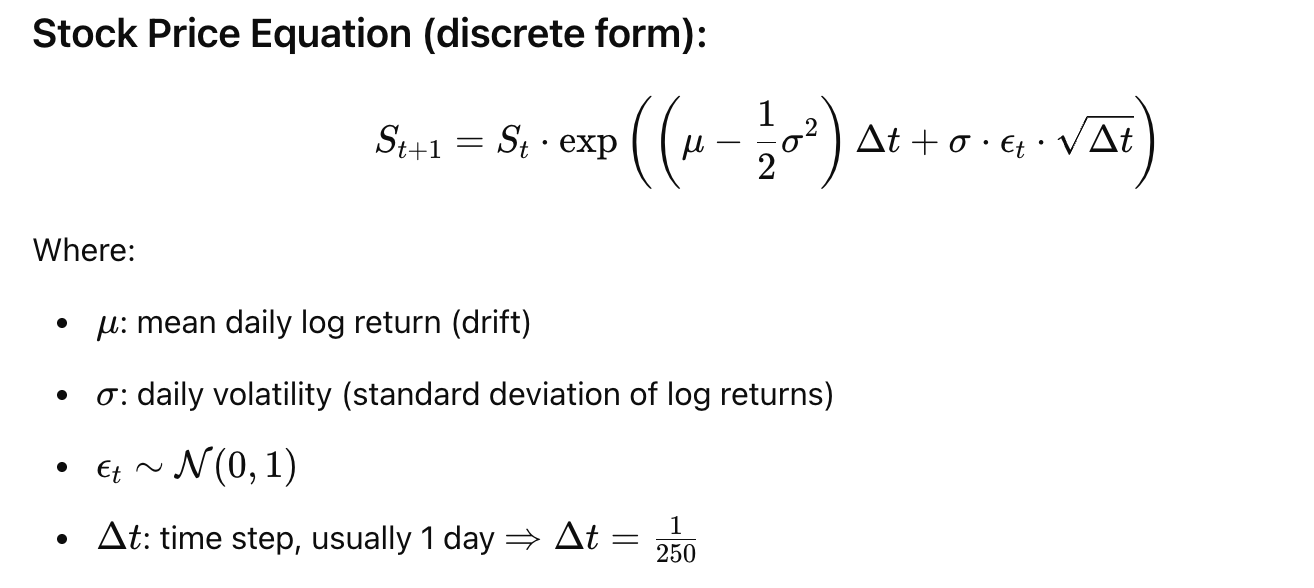

In [180]:

# * We create a blank price_list (250days x 10k scenarios), start from the current stock price, and populate the new price  list with returns that reflect the drift. 

# * Finally when we plot the returns we can see that the trend of the drift is continued into the future. 
 

#### Quantifications - Examine the worst, average, best scenarios and the probability distribution.


In [181]:
# Quantifications - Examine the worst, average, best scenarios and the probability distribution.
 
final_prices = price_paths[-1] # last row of price_paths
                               # the final outcome on 250th day for each 10k scenarios
best_case = final_prices.max()
worst_case = final_prices.min()
average_case = final_prices.mean()

print(f"Best Case (Max):     ${best_case:.2f}")
print(f"Worst Case (Min):    ${worst_case:.2f}")
print(f"Average Case (Mean): ${average_case:.2f}")

lower_bound = np.percentile(final_prices, 2.5)
upper_bound = np.percentile(final_prices, 97.5)

print(f"95% Confidence Interval: ${lower_bound:.2f} - ${upper_bound:.2f}")

prob_above_160 = np.sum(final_prices > 160) / len(final_prices)
prov_below_150 = np.sum(final_prices < 150) / len(final_prices)

print(f"Probability MSFT > $160: {prob_above_160:.2%}")
print(f"Probability MSFT < $150: {prob_below_150:.2%}")

# Set up condifence intervals manually (however this assumes nomrality using np.percentile yields a more acc. answer)
Mean_Day250Prices = price_list[-1].mean()
SD_Day250Prices = price_list[-1].std()
UpperInterval_1SD = Mean_Day250Prices + 1 * SD_Day250Prices
LowerInterval_1SD = Mean_Day250Prices - 1 * SD_Day250Prices
UpperInterval_2SD = Mean_Day250Prices + 2 * SD_Day250Prices
LowerInterval_2SD = Mean_Day250Prices - 2 * SD_Day250Prices

# Print out the price range within the confidence intervals
print('\n' + 'Confidence Intervals')
print(f'1 Sigma (1 S.D.): 68% confident that price after 250 days will fall between: ${round(LowerInterval_1SD, 2)} and ${round(UpperInterval_1SD, 2)}')
print(f'2 Sigma (2 S.D.): 95% confident that price after 250 days will fall between: ${round(LowerInterval_2SD, 2)} and ${round(UpperInterval_2SD, 2)}')



Best Case (Max):     $161.63
Worst Case (Min):    $139.71
Average Case (Mean): $150.48
95% Confidence Interval: $144.97 - $156.22
Probability MSFT > $160: 0.05%
Probability MSFT < $150: 43.82%

Confidence Intervals
1 Sigma (1 S.D.): 68% confident that price after 250 days will fall between: $109.39 and $204.66
2 Sigma (2 S.D.): 95% confident that price after 250 days will fall between: $61.75 and $252.29


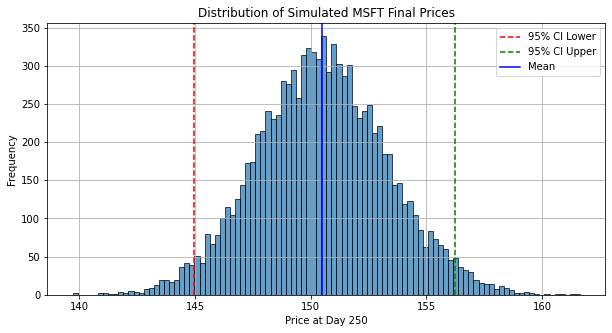

In [182]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.hist(final_prices, bins=100, edgecolor='black', alpha=0.7)
plt.axvline(lower_bound, color='red', linestyle='--', label='95% CI Lower')
plt.axvline(upper_bound, color='green', linestyle='--', label='95% CI Upper')
plt.axvline(average_case, color='blue', linestyle='-', label='Mean')
plt.title('Distribution of Simulated MSFT Final Prices')
plt.xlabel('Price at Day 250')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

# The empirical rule, or the 68-95-99.7 rule:
# Around 68% of scores are within 1 standard deviation of the mean. 
# Around 95% of scores are within 2 standard deviations of the mean. 
# Around 99.7% of scores are within 3 standard deviations of the mean

In [183]:
## Recap, Stock Prediction Model
"""
* Observations: we imported 20 years of MSFT prices data from Yahoo Finance and calculate daily log returns.

* Distributions: using log returns we calculated mean, stdev, and variance. Then we calculated drift, which is
  the mean of the returns, with consideration of the variance.

* Simulations: we generated a random normal distribution to simulate 10,000 scenarios of the following year daily 
  returns.

* Quantifications: Based on the 10,000 results, we examined the best, worst, and avg stock price scenarios. We also
  looked at the range of stock prices (confidence intervals) with a 68% and 95% probability.

"""

'\n* Observations: we imported 20 years of MSFT prices data from Yahoo Finance and calculate daily log returns.\n\n* Distributions: using log returns we calculated mean, stdev, and variance. Then we calculated drift, which is\n  the mean of the returns, with consideration of the variance.\n\n* Simulations: we generated a random normal distribution to simulate 10,000 scenarios of the following year daily \n  returns.\n\n* Quantifications: Based on the 10,000 results, we examined the best, worst, and avg stock price scenarios. We also\n  looked at the range of stock prices (confidence intervals) with a 68% and 95% probability.\n\n'